# Benchmark Evaluation Script

## How to Run 

These are the high level tasks required to replicate the test scenario:
(*paths are considered relative inside the Docker container!*)

1. Start the devcontainer and wait for the container and the workspace to build. 
1. Ensure the `BUILD_BENCHMARK` flag in the `src/soar_ros/CMakeLists.txt` is `ON`; If a change is needed, rebuild the workspace via the build instructions in src/soar_ros/test/benchmark/README.md
1. Create a virtual python environment `python3 -m venv .venv`, activate it (`source .venv/bin/activate`) and install the requirements `pip install -r src/soar_ros/test/benchmark/requirements.txt`
1. Navigate to the `src/soar_ros/test/benchmark/` directory and run the `./benchmark.sh <channels>` script **as instructed below**.
1. Run this Jupyter Notebook to see the results.

## Explanation 

This is the evaluation script for the `soar_ros` benchmark. This benchmark compares three different scenarios:

1. `soar_ros` running without any messaging (no load)
2. `soar_ros` running in single input/ single output (SISO) mode
3. `soar_ros` running in multiple input/ multiple output (MIMO) mode

The _no load_ scenario is intended to capture the performance baseline on the
machine running the benchmark, so relative performance can be measured. 

The general usage of the script is:

```shell
./benchmark.sh <number_of_channels> 
```

**After each frequency, press `CTRL + C` to continue to the next frequency test!** 
Tests will be completed, once you only see the log message `[INFO]
[1766760154.788314964] [system]: Soar decision cycle executed`.

In order to run the tests on your machine, run the following commands on the terminal.

1. No Messaging:

    ```shell
    ./benchmark.sh 0
    ```

    **Special case:** Just stop the benchmark with `CTRL + C` after 5-10
    seconds. There is no need for testing multiple frequencies since the Soar
    kernel is running at maximum speed in any case.

2. SISO

    ```shell
    ./benchmark.sh 1
    ```

3. MIMO

    ```shell
    ./benchmark.sh 2
    ```

The tests save the logs and extracted data via the `parse-logs.py` script into
the `out/<timestamp>/` directory. In order for the following script to analyze
and compare the different test szenarios and results, set up the correct paths
in the next cell **based on your directory names**. The directory names are in
the following schema:

```shell
./out/<ISO8601 timestamp>_CHANNELS_<number_channels>/
```

Only the `<ISO8601 timestamp>_CHANNELS_<number_channels>` part is required for the 
directory names.

In [ ]:
no_load_directory = "2026-02-11T10:12:15_CHANNELS_0" # results from ./benchmark.sh 0
siso_directory = "2026-02-11T10:12:30_CHANNELS_1" # results from ./benchmark.sh 1
mimo_directory = "2026-02-11T10:13:45_CHANNELS_2" # results from ./benchmark.sh 2

In [ ]:
# general settings & imports
%matplotlib widget

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

export_figures = False
plt.rcParams['axes.grid'] = True

In [ ]:
# Distribution plot of decision cycle frequencies (No Load) using matplotlib
# Compute histograms and normalize to 100%
def compare_soar_kernel_frequencies(data_frame, scenario: str):
    """
    Plot distribution of Soar decision cycle frequencies.
    Creates a single plot with all unique frequencies overlaid.
    
    Parameters:
    -----------
    data_frame : pandas.DataFrame
        Soar decision cycle dataframe with 'frequency' and 'timestamp' columns
    scenario : str
        Scenario name for saving the plot (e.g., "no_load", "siso", "mimo")
    """
    # Get all unique frequencies from the dataframe
    unique_frequencies = sorted(data_frame["frequency"].unique())
    
    plt.figure()
    
    for frequency in unique_frequencies:
        df = data_frame[data_frame["frequency"] == frequency]
        
        if df.empty:
            print(f"Skipping frequency {frequency} Hz - no data available")
            continue
        
        freqs = 1 / df["timestamp"].diff().dropna()
        hist, bins = np.histogram(freqs, bins=50)
        hist = hist / hist.sum() * 100
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        plt.bar(bin_centers, hist, width=(bins[1]-bins[0]), alpha=0.5, label=f"{frequency} Hz")

        print(f"{scenario} {frequency} Hz: Mean = {freqs.mean():.2f} Hz, SD = {freqs.std():.2f} Hz")

    
    plt.xlabel("Frequency (Hz)")
    plt.xlim(left=0)
    plt.ylabel("Count (%)")
    plt.title(f"Distribution of Soar Decision Cycle Frequencies - {scenario}")
    plt.legend()
    plt.show()
    
    if not os.path.exists("out/images"):
        os.makedirs("out/images")
    plt.title("")
    plt.savefig(f"out/images/kernel_frequency_comparison_{scenario}.pdf", dpi=300)

def analyze_sender_frequency(df,show_plots=False):
    for freq in df["frequency"].unique():
        df_subset = df[(df["frequency"] == freq)]

        for channel in df_subset["channel"].unique():
            df_channel = df_subset[df_subset["channel"] == channel].sort_values("counter")
            # Reset the index so x-axis starts from 0 for each new plot
            mean = (1/df_channel["sender_time"].diff()).mean()
            sd = (1/df_channel["sender_time"].diff()).std()
            print(f"F {freq} Channel {channel} M: {mean:0.6} Hz, SD: {sd:0.6} Hz")

def plot_dual_axis_comparison(test_data, soar_data, title_prefix="", figsize=(10, 6)):
    """
    Plot test data duration and Soar kernel frequency on aligned dual y-axes.
    Creates a separate plot for each unique frequency in test_data.
    
    Parameters:
    -----------
    test_data : pandas.DataFrame
        Test results dataframe with 'frequency', 'receive_time', and 'duration' columns
    soar_data : pandas.DataFrame
        Soar decision cycle dataframe with 'frequency' and 'timestamp' columns
    title_prefix : str
        Prefix for the plot title (e.g., "SISO", "MIMO")
    figsize : tuple
        Figure size (width, height)
    """
    # Get all unique frequencies from test_data
    unique_frequencies = sorted(test_data["frequency"].unique())
    
    for frequency in unique_frequencies:
        fig, ax1 = plt.subplots(figsize=figsize)
        
        # Data preparation
        df_test = test_data[test_data["frequency"] == frequency]
        df_soar = soar_data[soar_data["frequency"] == frequency]
        
        if df_test.empty or df_soar.empty:
            print(f"Skipping frequency {frequency} Hz - no data available")
            plt.close(fig)
            continue
        
        global_start = min(df_test["receive_time"].min(), df_soar["timestamp"].min())
        
        rel_receive_time = df_test["receive_time"] - global_start
        rel_timestamp = df_soar["timestamp"] - global_start
        freqs = 1 / df_soar["timestamp"].diff().dropna()
        
        min_time = min(rel_receive_time.min(), rel_timestamp.min())
        max_time = max(rel_receive_time.max(), rel_timestamp.max())
        
        # Left y-axis: Duration
        # color1 = 'tab:blue'
        ax1.set_xlabel("Relative Time (s)")
        ax1.set_ylabel("Duration (s)")

        for channel in df_test["channel"].unique():
            df_channel = df_test[df_test["channel"] == channel]
            ax1.plot(rel_receive_time[df_channel.index], df_channel["duration"], marker='o', linestyle='', markersize=2, label=f"Duration Channel {channel}", zorder=2)

        ax1.tick_params(axis='y')
        ax1.set_xlim(min_time, max_time)
        ax1.set_zorder(2)
        ax1.patch.set_visible(False)

        ax2 = ax1.twinx()
        ax2.set_zorder(1)
        color2 = 'tab:green'
        ax2.set_ylabel("Soar Kernel Frequency (Hz)", color=color2)
        # Plot frequency curve and fill under the curve until 0
        # ax2.plot(rel_timestamp[1:], freqs, marker='.', linestyle='', markersize=2, color=color2, label="Frequency", alpha=0.8)
        ax2.fill_between(rel_timestamp[1:], freqs, 0, color=color2, alpha=0.2, zorder=0, linestyle="")
        ax2.tick_params(axis='y', labelcolor=color2)

        
        ylim1 = ax1.get_ylim()
        len1 = ylim1[1]-ylim1[0]
        yticks1 = ax1.get_yticks()
        rel_dist = [(y-ylim1[0])/len1 for y in yticks1]
        ylim2 = ax2.get_ylim()
        len2 = ylim2[1]-ylim2[0]
        yticks2 = [ry*len2+ylim2[0] for ry in rel_dist]

        #My best attempt
        ax2.set_yticks(yticks2)
        ax2.set_ylim(ylim2)  

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        title = f"{title_prefix} {frequency} Hz: Duration and Soar Kernel Frequency vs Relative Time"
        fig.suptitle(title)
        # fig.tight_layout()
        ax2.grid(False)
        plt.show()
        if not os.path.exists("out/images"):
            os.makedirs("out/images")

        plt.title("")
        plt.savefig(f"out/images/{title.replace(' ', '_')}.pdf", dpi=300)

def trim_soar_timeseries(soar_df, duration_df, soar_time_col="timestamp", duration_time_col="receive_time", frequency_col="frequency"):
    trimmed_frames = []
    for freq in sorted(duration_df[frequency_col].unique()):
        duration_subset = duration_df[duration_df[frequency_col] == freq]
        soar_subset = soar_df[soar_df[frequency_col] == freq]
        if duration_subset.empty or soar_subset.empty:
            continue
        min_time = duration_subset[duration_time_col].min() - 2.0
        max_time = duration_subset[duration_time_col].max() + 2.0
        trimmed = soar_subset[(soar_subset[soar_time_col] >= min_time) & (soar_subset[soar_time_col] <= max_time)].copy()
        print(
            f"Trimmed {freq} Hz Soar timeseries to range: {min_time:.3f} - {max_time:.3f} "
            f"(original: {soar_subset[soar_time_col].min():.3f} - {soar_subset[soar_time_col].max():.3f})"
        )
        trimmed_frames.append(trimmed)
    if not trimmed_frames:
        return soar_df.iloc[0:0].copy()
    return pd.concat(trimmed_frames, ignore_index=True)

In [ ]:
# Preloading all data for comparisons
# no_load df
base_path = os.path.join("out", no_load_directory,"data")
df_no_load = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))

# SISO df
base_path = os.path.join("out", siso_directory,"data")
df_siso = pd.read_csv(os.path.join(base_path,"combined_message_results.csv"))
df_siso_soar = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))
df_siso_soar_trimmed = trim_soar_timeseries(df_siso_soar, df_siso)

Trimmed 250.0 Hz Soar timeseries to range: 1770804753.047 - 1770804769.048 (original: 1770804751.039 - 1770804768.625)
Trimmed 500.0 Hz Soar timeseries to range: 1770804780.598 - 1770804790.938 (original: 1770804778.908 - 1770804791.318)
Trimmed 1000.0 Hz Soar timeseries to range: 1770804803.321 - 1770804811.611 (original: 1770804801.622 - 1770804811.535)
Trimmed 250.0 Hz Soar timeseries to range: 1770804827.884 - 1770804860.626 (original: 1770804826.178 - 1770804859.828)
Trimmed 500.0 Hz Soar timeseries to range: 1770804871.794 - 1770804905.827 (original: 1770804870.117 - 1770804906.951)
Trimmed 1000.0 Hz Soar timeseries to range: 1770804918.929 - 1770804954.853 (original: 1770804917.239 - 1770804954.124)


## Scenario: No Load Analysis

no_load 500.0 Hz: Mean = 17637.39 Hz, SD = 2742.46 Hz


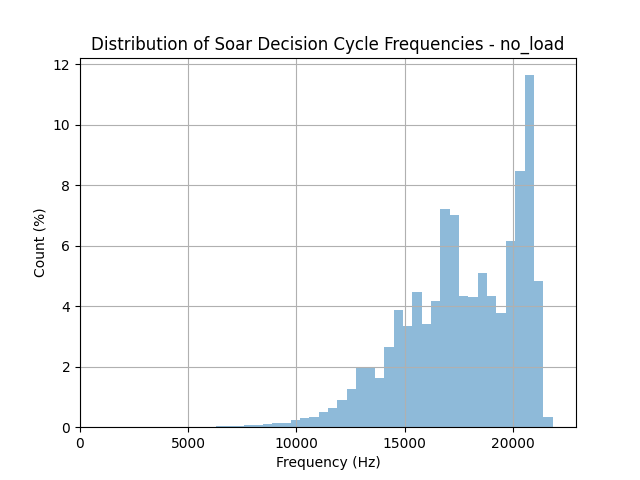

In [ ]:
compare_soar_kernel_frequencies(df_no_load[df_no_load["frequency"]==500.0], "no_load")

As visible in the distribution diagram, the input frequency does not have an impact on the Soar kernel execution speed.

## Scenario: SISO Analysis

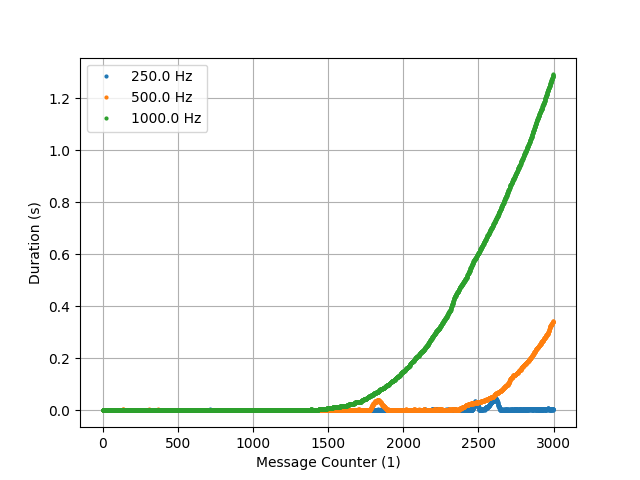

In [ ]:
plt.figure()
plt.xlabel('Message Counter (1)')
plt.ylabel('Duration (s)')

for frequencies in sorted(df_siso['frequency'].unique()):
    freq_df = df_siso[df_siso['frequency'] == frequencies]
    for channel in freq_df['channel'].unique():
        df_channel = freq_df[freq_df['channel'] == channel].sort_values(by='counter')
        plt.plot(df_channel['counter'], df_channel['duration'], marker='o', linestyle='', label=f'{frequencies} Hz',markersize=2)

plt.legend()
plt.show()

siso 250.0 Hz: Mean = 15289.42 Hz, SD = 4372.25 Hz
siso 500.0 Hz: Mean = 15076.11 Hz, SD = 4743.69 Hz
siso 1000.0 Hz: Mean = 15573.70 Hz, SD = 4812.67 Hz


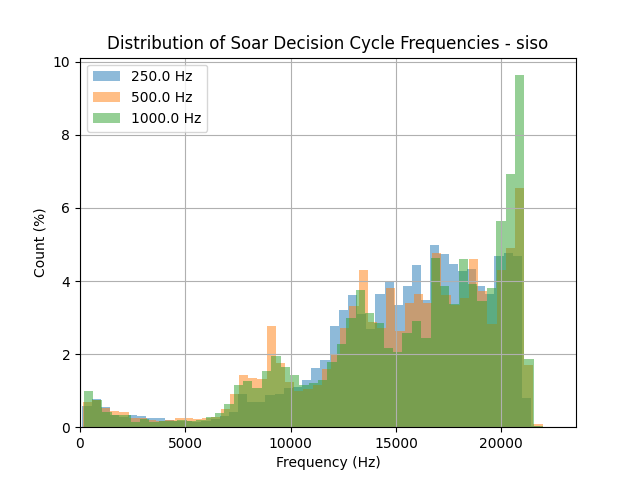

In [ ]:
compare_soar_kernel_frequencies(df_siso_soar, "siso")

In [ ]:
analyze_sender_frequency(df_siso)

F 500.0 Channel 0 M: 500.233 Hz, SD: 11.9792 Hz
F 250.0 Channel 0 M: 250.015 Hz, SD: 1.91021 Hz
F 1000.0 Channel 0 M: 1001.11 Hz, SD: 33.9638 Hz


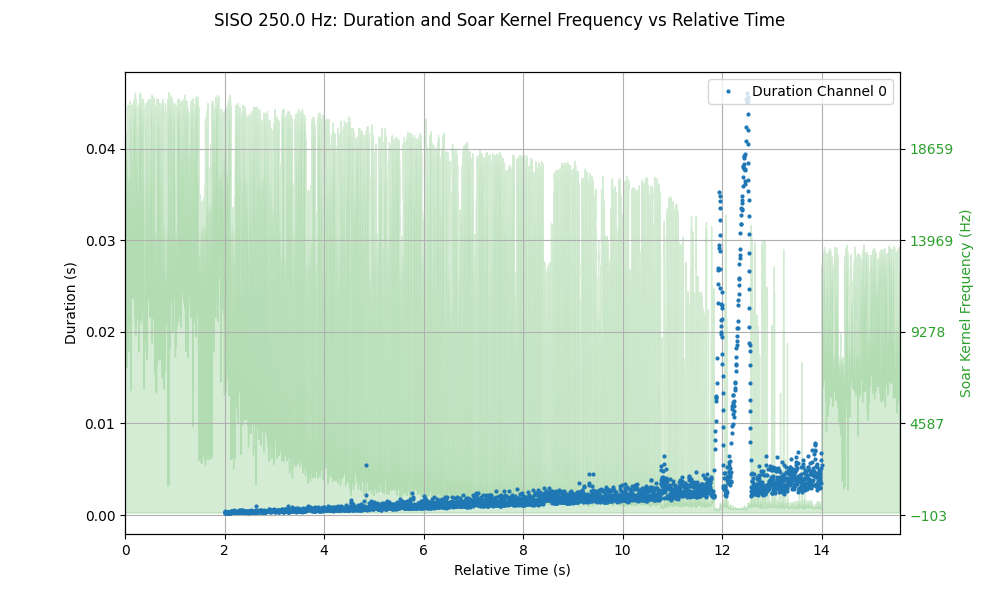

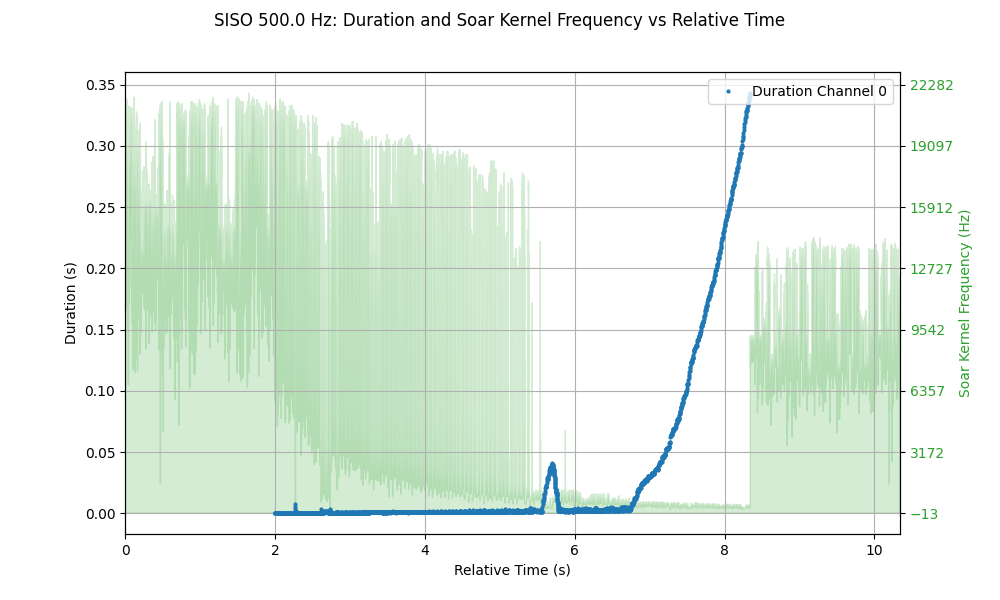

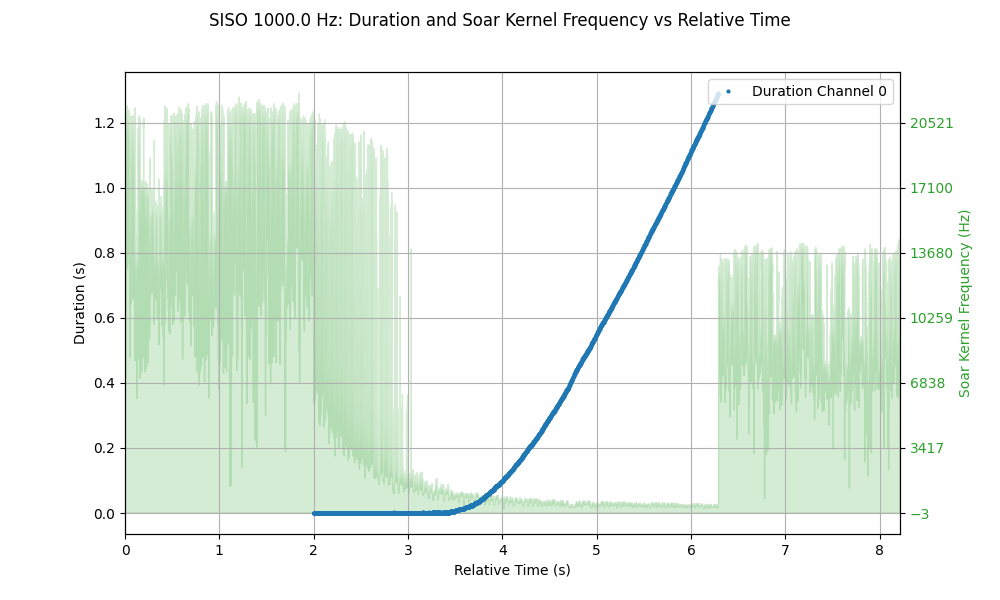

In [ ]:
plot_dual_axis_comparison(df_siso, df_siso_soar_trimmed, "SISO")

## Scenario MIMO Analysis

mimo 250.0 Hz: Mean = 15283.18 Hz, SD = 5475.09 Hz
mimo 500.0 Hz: Mean = 14386.47 Hz, SD = 6302.61 Hz
mimo 1000.0 Hz: Mean = 15138.45 Hz, SD = 5929.44 Hz


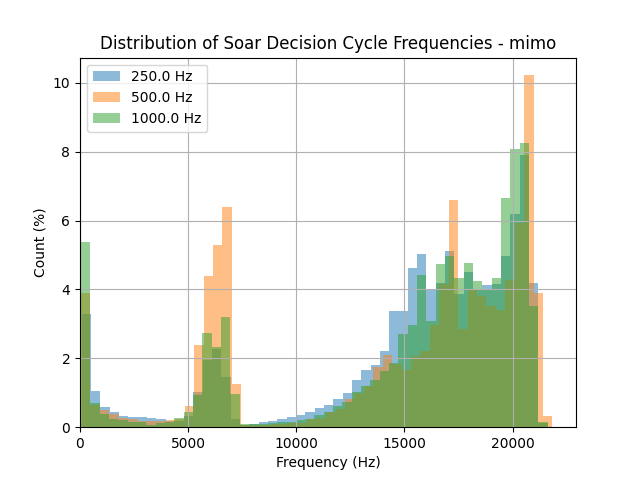

In [ ]:
compare_soar_kernel_frequencies(df_mimo_soar, "mimo")

In [ ]:
analyze_sender_frequency(df_mimo)

F 500.0 Channel 0 M: 500.145 Hz, SD: 8.58334 Hz
F 500.0 Channel 1 M: 500.178 Hz, SD: 9.50202 Hz
F 250.0 Channel 0 M: 250.036 Hz, SD: 3.07449 Hz
F 250.0 Channel 1 M: 250.045 Hz, SD: 3.44954 Hz
F 1000.0 Channel 0 M: 1001.16 Hz, SD: 34.7089 Hz
F 1000.0 Channel 1 M: 1001.25 Hz, SD: 36.0359 Hz


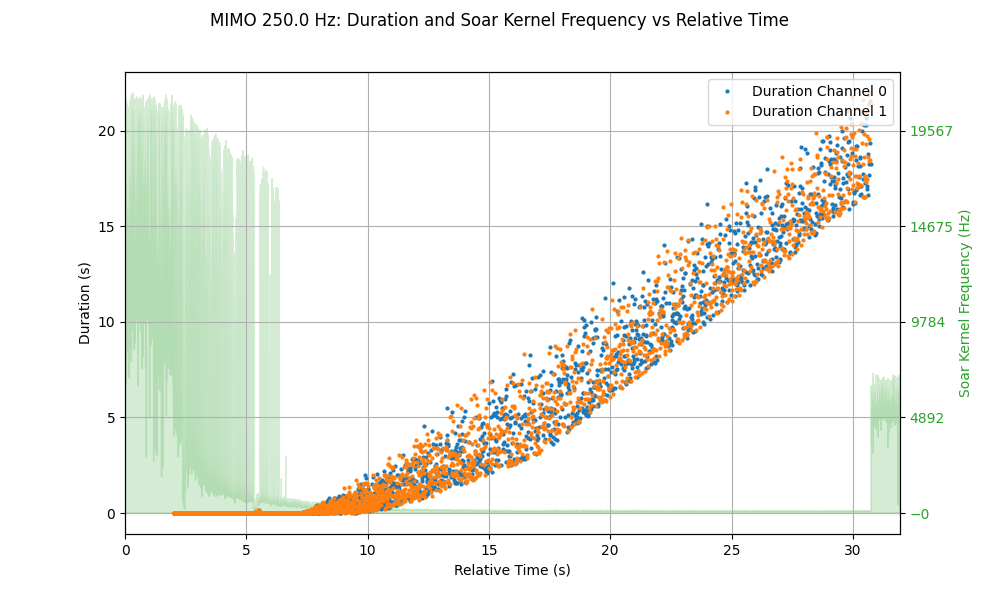

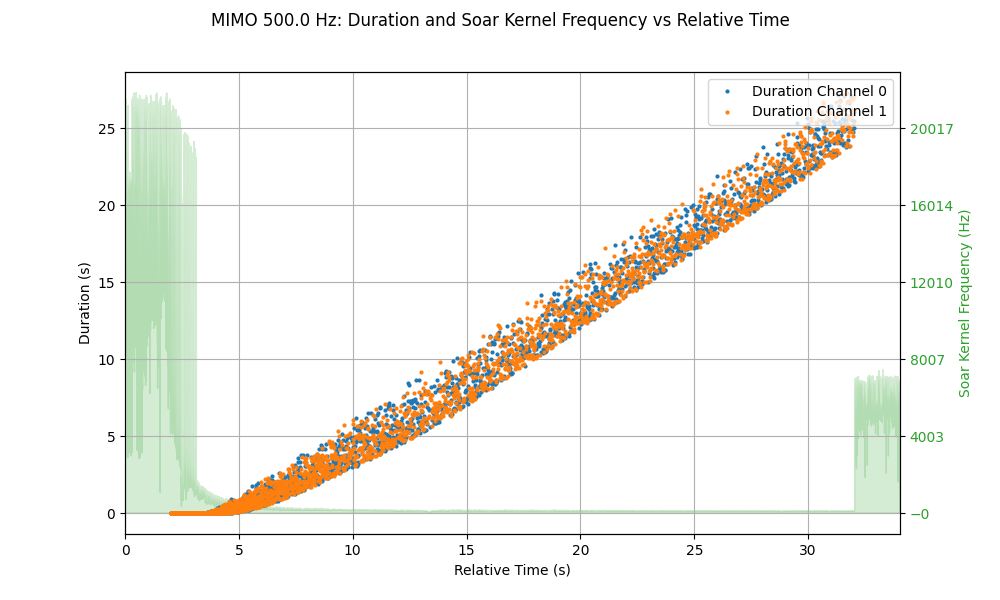

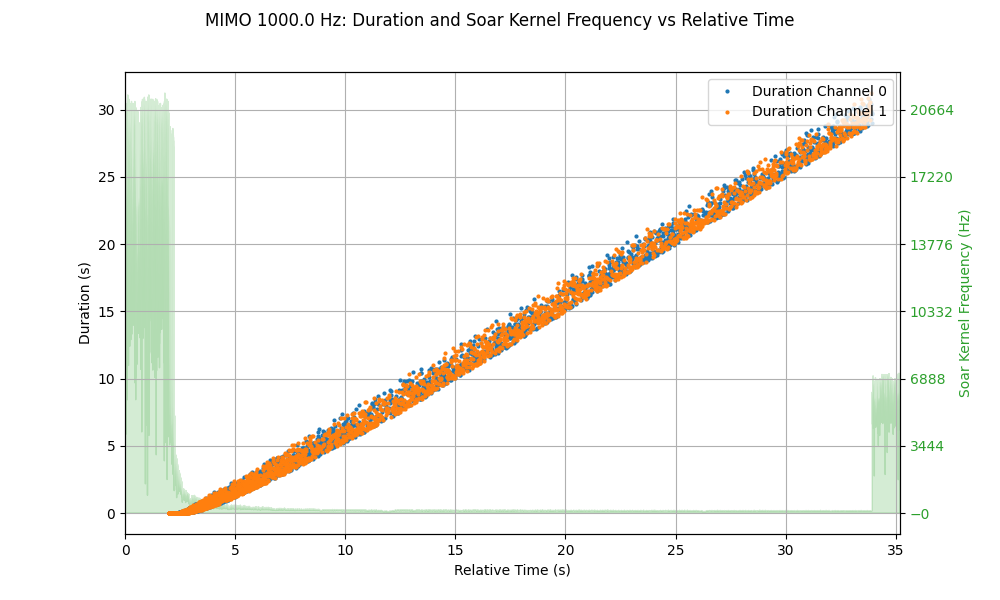

In [ ]:
plot_dual_axis_comparison(df_mimo, df_mimo_soar_trimmed, "MIMO")

## Why do we see an increase in duration?

```log
1767116131.6864271 [System-2] [INFO] [1767116131.686303633] [system]: Soar decision cycle executed

1767116131.6873047 [Sender-3] [INFO] [1767116131.687083133] [sender]: Published to input: frame_id=135_0
1767116131.6873958 [Sender-3] [INFO] [1767116131.687101299] [sender]: Published to input: frame_id=135_1

1767116131.6875758 [System-2] [INFO] [1767116131.687149924] [system]: Sending on output1
1767116131.6876531 [System-2] [INFO] [1767116131.687211258] [system]: Received subscription msg on input1

1767116131.6877210 [Receiver-1] [INFO] [1767116131.687281674] [receiver]: Received on output: frame_id=106_1

1767116131.6877737 [System-2] [INFO] [1767116131.687299008] [system]: Received subscription msg on input0
1767116131.6886792 [System-2] [INFO] [1767116131.688557133] [system]: benchmark: 4907:    O: O5010 (add-frame-id-to-output1)
1767116131.6888061 [System-2] [INFO] [1767116131.688694424] [system]: Soar decision cycle executed
```

In one decision cycle, multiple intputs can be received but on the output link, only one o-supported item can be sent.

Possible future analysis: 

- [ ] Do a profiling analysis to see where the Soar kernel thread loses the most time? (Guess: parsing Soar to ROS messages)

In [ ]:
normal = "2026-02-11T16:19:26_CHANNELS_1-8000messages"
auto_delete_io = "2026-02-11T16:22:16_CHANNELS_1-8000messages-autodeleteio"

base_path = os.path.join("out", normal,"data")
df_normal = pd.read_csv(os.path.join(base_path,"combined_message_results.csv"))
df_normal_soar = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))
df_normal_soar_trimmed = trim_soar_timeseries(df_normal_soar, df_normal)

base_path = os.path.join("out", auto_delete_io,"data")
df_auto_delete_io = pd.read_csv(os.path.join(base_path,"combined_message_results.csv"))
df_auto_delete_io_soar = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))
df_auto_delete_io_soar_trimmed = trim_soar_timeseries(df_auto_delete_io_soar, df_auto_delete_io)

Trimmed 200.0 Hz Soar timeseries to range: 1770826768.498 - 1770826838.768 (original: 1770826766.499 - 1770826837.784)
Trimmed 200.0 Hz Soar timeseries to range: 1770826938.550 - 1770826982.545 (original: 1770826936.557 - 1770826994.789)


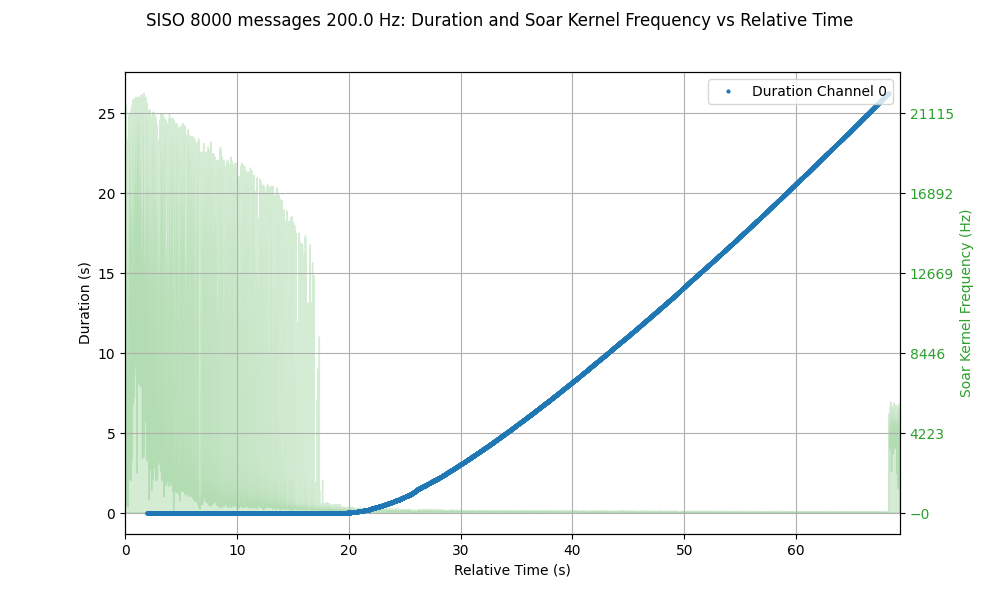

In [ ]:
plot_dual_axis_comparison(df_normal, df_normal_soar_trimmed, "SISO 8000 messages")

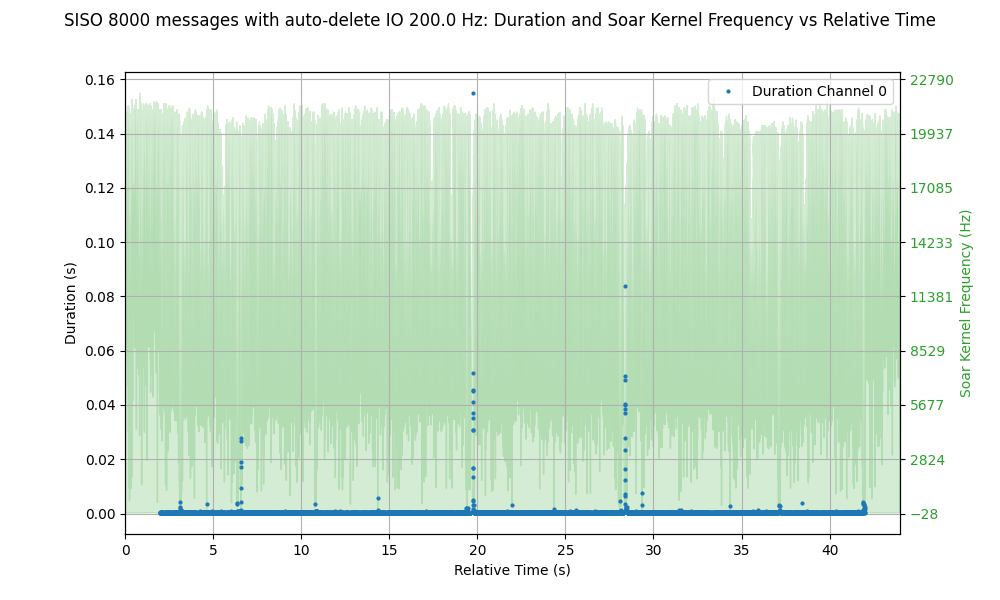

In [ ]:
plot_dual_axis_comparison(df_auto_delete_io, df_auto_delete_io_soar_trimmed, "SISO 8000 messages with auto-delete IO")

In [ ]:
# auto_delete_io_500 = "2026-02-11T16:34:46_CHANNELS_1"
auto_delete_io_1500 = "2026-02-11T16:37:57_CHANNELS_1"
base_path = os.path.join("out", auto_delete_io_1500,"data")
df_auto_delete_io_1500 = pd.read_csv(os.path.join(base_path,"combined_message_results.csv"))
df_auto_delete_io_soar_1500 = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))
df_auto_delete_io_soar_trimmed_1500 = trim_soar_timeseries(df_auto_delete_io_soar_1500, df_auto_delete_io_1500)

Trimmed 1500.0 Hz Soar timeseries to range: 1770827877.011 - 1770828469.817 (original: 1770827878.127 - 1770828500.276)


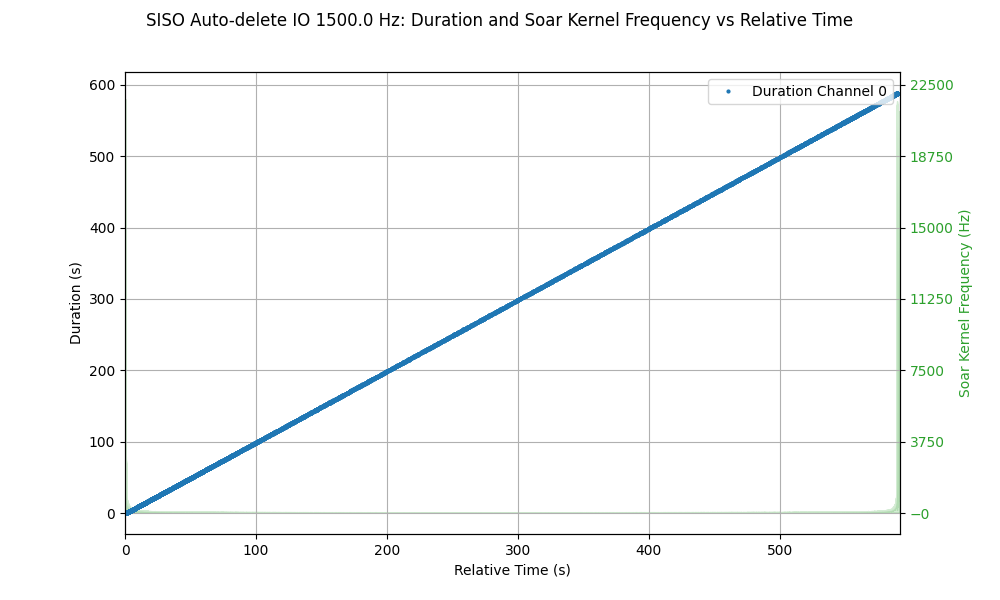

In [ ]:
plot_dual_axis_comparison(df_auto_delete_io_1500,df_auto_delete_io_soar_trimmed_1500,"SISO Auto-delete IO")